Dataset Loading & Initial Exploration

In [1]:


import pandas as pd

# Load the dataset from the given path
file_path = "/content/6G_Interbank_Settlement_Dataset.csv"
df = pd.read_csv(file_path)

# Display basic information
print("=== DATASET SHAPE ===")
print(df.shape)

print("\n=== COLUMN NAMES ===")
print(df.columns.tolist())

print("\n=== FIRST 5 ROWS ===")
display(df.head())

print("\n=== DATA TYPES ===")
print(df.dtypes)

print("\n=== MISSING VALUES PER COLUMN ===")
print(df.isnull().sum())


=== DATASET SHAPE ===
(1000, 15)

=== COLUMN NAMES ===
['Transaction ID', 'Bank Sender', 'Bank Receiver', 'Transaction Volume', 'Transaction Fee (%)', 'Processing Time (ms)', 'Settlement Speed (ms)', 'Shard ID', 'Shard Load (%)', 'Congestion Level', 'Liquidity Provided ($)', 'Staking Rewards (%)', 'TPS', 'Scalability Score', 'Target']

=== FIRST 5 ROWS ===


,Transaction ID,Bank Sender,Bank Receiver,Transaction Volume,Transaction Fee (%),Processing Time (ms),Settlement Speed (ms),Shard ID,Shard Load (%),Congestion Level,Liquidity Provided ($),Staking Rewards (%),TPS,Scalability Score,Target
0,TXN0001,151,233,6036.827820,1.477376,141.546414,881.352366,4,99.130026,Low,28007.427331,4.943966,203.148202,81.152209,1
1,TXN0002,192,207,28974.320590,0.476543,107.323887,367.625378,2,41.203783,Medium,21312.448953,4.751058,73.552591,90.152139,1
2,TXN0003,114,239,1900.014210,0.669761,178.478951,246.284189,2,73.764760,Medium,55334.219451,4.448612,238.570583,77.572131,1
3,TXN0004,171,282,24635.462696,1.348072,289.209829,708.059179,5,24.161900,High,32548.802301,4.556522,55.127730,89.843286,1
4,TXN0005,160,241,11307.129416,0.104089,279.752808,134.277671,10,29.091683,Low,64745.988768,2.871397,112.343947,68.192061,1



=== DATA TYPES ===
Transaction ID             object
Bank Sender                 int64
Bank Receiver               int64
Transaction Volume        float64
Transaction Fee (%)       float64
Processing Time (ms)      float64
Settlement Speed (ms)     float64
Shard ID                    int64
Shard Load (%)            float64
Congestion Level           object
Liquidity Provided ($)    float64
Staking Rewards (%)       float64
TPS                       float64
Scalability Score         float64
Target                      int64
dtype: object

=== MISSING VALUES PER COLUMN ===
Transaction ID            0
Bank Sender               0
Bank Receiver             0
Transaction Volume        0
Transaction Fee (%)       0
Processing Time (ms)      0
Settlement Speed (ms)     0
Shard ID                  0
Shard Load (%)            0
Congestion Level          0
Liquidity Provided ($)    0
Staking Rewards (%)       0
TPS                       0
Scalability Score         0
Target                    0
d

Data Cleaning & Network-Ready Transformation

In [2]:

import pandas as pd

# Reload dataset to ensure clean state
file_path = "/content/6G_Interbank_Settlement_Dataset.csv"
df = pd.read_csv(file_path)

print("Original dataset shape:", df.shape)

# Rename key columns for consistency
df_clean = df.rename(columns={
    "Bank Sender": "sender",
    "Bank Receiver": "receiver",
    "Transaction Volume": "weight"
})

# Remove self-loops (sender == receiver)
initial_rows = df_clean.shape[0]
df_clean = df_clean[df_clean["sender"] != df_clean["receiver"]]
removed_rows = initial_rows - df_clean.shape[0]

# Create network edge list (keep relevant columns)
edge_list = df_clean[
    ["sender", "receiver", "weight",
     "Transaction Fee (%)",
     "Processing Time (ms)",
     "Settlement Speed (ms)",
     "Shard Load (%)",
     "Congestion Level",
     "Liquidity Provided ($)",
     "Staking Rewards (%)",
     "TPS",
     "Scalability Score",
     "Target"]
].copy()

print("\n=== CLEANING SUMMARY ===")
print(f"Self-loop transactions removed: {removed_rows}")
print(f"Final edge list shape: {edge_list.shape}")

print("\n=== EDGE LIST PREVIEW ===")
display(edge_list.head())

print("\n=== BASIC WEIGHT STATISTICS ===")
print(edge_list["weight"].describe())


Original dataset shape: (1000, 15)

=== CLEANING SUMMARY ===
Self-loop transactions removed: 0
Final edge list shape: (1000, 13)

=== EDGE LIST PREVIEW ===


,sender,receiver,weight,Transaction Fee (%),Processing Time (ms),Settlement Speed (ms),Shard Load (%),Congestion Level,Liquidity Provided ($),Staking Rewards (%),TPS,Scalability Score,Target
0,151,233,6036.827820,1.477376,141.546414,881.352366,99.130026,Low,28007.427331,4.943966,203.148202,81.152209,1
1,192,207,28974.320590,0.476543,107.323887,367.625378,41.203783,Medium,21312.448953,4.751058,73.552591,90.152139,1
2,114,239,1900.014210,0.669761,178.478951,246.284189,73.764760,Medium,55334.219451,4.448612,238.570583,77.572131,1
3,171,282,24635.462696,1.348072,289.209829,708.059179,24.161900,High,32548.802301,4.556522,55.127730,89.843286,1
4,160,241,11307.129416,0.104089,279.752808,134.277671,29.091683,Low,64745.988768,2.871397,112.343947,68.192061,1



=== BASIC WEIGHT STATISTICS ===
count     1000.000000
mean     25095.306401
std      13953.511587
min       1009.231578
25%      12556.219920
50%      25291.748582
75%      37180.400788
max      49856.829697
Name: weight, dtype: float64


Construct Directed, Weighted Network

In [3]:

import pandas as pd
import networkx as nx

# Reload and prepare cleaned edge list
file_path = "/content/6G_Interbank_Settlement_Dataset.csv"
df = pd.read_csv(file_path)

df_clean = df.rename(columns={
    "Bank Sender": "sender",
    "Bank Receiver": "receiver",
    "Transaction Volume": "weight"
})

df_clean = df_clean[df_clean["sender"] != df_clean["receiver"]]

edge_list = df_clean[
    ["sender", "receiver", "weight",
     "Transaction Fee (%)",
     "Processing Time (ms)",
     "Settlement Speed (ms)",
     "Shard Load (%)",
     "Congestion Level",
     "Liquidity Provided ($)",
     "Staking Rewards (%)",
     "TPS",
     "Scalability Score",
     "Target"]
].copy()

# Create directed weighted graph
G = nx.DiGraph()

# Add edges with attributes
for _, row in edge_list.iterrows():
    G.add_edge(
        row["sender"],
        row["receiver"],
        weight=row["weight"],
        transaction_fee=row["Transaction Fee (%)"],
        processing_time=row["Processing Time (ms)"],
        settlement_speed=row["Settlement Speed (ms)"],
        shard_load=row["Shard Load (%)"],
        congestion=row["Congestion Level"],
        liquidity=row["Liquidity Provided ($)"],
        staking_reward=row["Staking Rewards (%)"],
        tps=row["TPS"],
        scalability=row["Scalability Score"],
        target=row["Target"]
    )

# Basic network statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)

print("=== NETWORK SUMMARY ===")
print(f"Number of nodes (banks): {num_nodes}")
print(f"Number of edges (transactions): {num_edges}")
print(f"Network density: {density:.6f}")

# Degree statistics
in_degrees = [d for _, d in G.in_degree()]
out_degrees = [d for _, d in G.out_degree()]

print("\n=== DEGREE STATISTICS ===")
print(f"Average in-degree: {sum(in_degrees)/len(in_degrees):.2f}")
print(f"Average out-degree: {sum(out_degrees)/len(out_degrees):.2f}")
print(f"Max in-degree: {max(in_degrees)}")
print(f"Max out-degree: {max(out_degrees)}")


=== NETWORK SUMMARY ===
Number of nodes (banks): 200
Number of edges (transactions): 951
Network density: 0.023894

=== DEGREE STATISTICS ===
Average in-degree: 4.75
Average out-degree: 4.75
Max in-degree: 17
Max out-degree: 18


Network metric computation (systemic importance)

In [4]:


import pandas as pd
import networkx as nx

# Reload dataset and rebuild network to ensure clean state
file_path = "/content/6G_Interbank_Settlement_Dataset.csv"
df = pd.read_csv(file_path)

df_clean = df.rename(columns={
    "Bank Sender": "sender",
    "Bank Receiver": "receiver",
    "Transaction Volume": "weight"
})

df_clean = df_clean[df_clean["sender"] != df_clean["receiver"]]

edge_list = df_clean[
    ["sender", "receiver", "weight"]
].copy()

# Build directed weighted graph
G = nx.DiGraph()
for _, row in edge_list.iterrows():
    G.add_edge(row["sender"], row["receiver"], weight=row["weight"])

# --- Compute network metrics ---

print("Computing in-degree and out-degree centrality...")
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

print("Computing betweenness centrality (this may take a moment)...")
betweenness_centrality = nx.betweenness_centrality(G, weight="weight", normalized=True)

print("Computing eigenvector centrality (weighted)...")
eigenvector_centrality = nx.eigenvector_centrality(G, weight="weight", max_iter=1000)

# Combine metrics into a single dataframe
metrics_df = pd.DataFrame({
    "bank_id": list(G.nodes()),
    "in_degree_centrality": [in_degree_centrality[n] for n in G.nodes()],
    "out_degree_centrality": [out_degree_centrality[n] for n in G.nodes()],
    "betweenness_centrality": [betweenness_centrality[n] for n in G.nodes()],
    "eigenvector_centrality": [eigenvector_centrality[n] for n in G.nodes()]
})

# Rank banks by systemic importance (example: betweenness)
metrics_df["betweenness_rank"] = metrics_df["betweenness_centrality"].rank(ascending=False)

print("\n=== METRICS DATAFRAME SHAPE ===")
print(metrics_df.shape)

print("\n=== TOP 10 BANKS BY BETWEenness CENTRALITY ===")
display(metrics_df.sort_values("betweenness_centrality", ascending=False).head(10))

print("\n=== METRIC SUMMARY STATISTICS ===")
display(metrics_df.describe())


Computing in-degree and out-degree centrality...
Computing betweenness centrality (this may take a moment)...
Computing eigenvector centrality (weighted)...

=== METRICS DATAFRAME SHAPE ===
(200, 6)

=== TOP 10 BANKS BY BETWEenness CENTRALITY ===


,bank_id,in_degree_centrality,out_degree_centrality,betweenness_centrality,eigenvector_centrality,betweenness_rank
0,151.0,0.000000,0.055276,0.0,1.984458e-07,100.5
1,233.0,0.035176,0.000000,0.0,8.467089e-02,100.5
2,192.0,0.000000,0.050251,0.0,1.984458e-07,100.5
3,207.0,0.045226,0.000000,0.0,7.919600e-02,100.5
4,114.0,0.000000,0.045226,0.0,1.984458e-07,100.5
5,239.0,0.080402,0.000000,0.0,1.093457e-01,100.5
6,171.0,0.000000,0.040201,0.0,1.984458e-07,100.5
7,282.0,0.035176,0.000000,0.0,6.920072e-02,100.5
8,160.0,0.000000,0.060302,0.0,1.984458e-07,100.5
9,241.0,0.050251,0.000000,0.0,1.168055e-01,100.5



=== METRIC SUMMARY STATISTICS ===


,bank_id,in_degree_centrality,out_degree_centrality,betweenness_centrality,eigenvector_centrality,betweenness_rank
count,200.000000,200.000000,200.000000,200.0,2.000000e+02,200.0
mean,199.500000,0.023894,0.023894,0.0,4.729729e-02,100.5
std,57.879185,0.025975,0.026310,0.0,5.269583e-02,0.0
min,100.000000,0.000000,0.000000,0.0,1.984458e-07,100.5
25%,149.750000,0.000000,0.000000,0.0,1.984458e-07,100.5
50%,199.500000,0.007538,0.007538,0.0,1.162372e-02,100.5
75%,249.250000,0.045226,0.045226,0.0,8.943948e-02,100.5
max,299.000000,0.085427,0.090452,0.0,1.871339e-01,100.5


Composite Systemic Risk Scoring

In [5]:
import pandas as pd
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

# Reload dataset and rebuild network
file_path = "/content/6G_Interbank_Settlement_Dataset.csv"
df = pd.read_csv(file_path)

df_clean = df.rename(columns={
    "Bank Sender": "sender",
    "Bank Receiver": "receiver",
    "Transaction Volume": "weight"
})

df_clean = df_clean[df_clean["sender"] != df_clean["receiver"]]

edge_list = df_clean[["sender", "receiver", "weight"]].copy()

G = nx.DiGraph()
for _, row in edge_list.iterrows():
    G.add_edge(row["sender"], row["receiver"], weight=row["weight"])

# Compute network metrics
in_deg = nx.in_degree_centrality(G)
out_deg = nx.out_degree_centrality(G)
betweenness = nx.betweenness_centrality(G, weight="weight", normalized=True)
eigenvector = nx.eigenvector_centrality(G, weight="weight", max_iter=1000)

# Create metrics dataframe
risk_df = pd.DataFrame({
    "bank_id": list(G.nodes()),
    "in_degree": [in_deg[n] for n in G.nodes()],
    "out_degree": [out_deg[n] for n in G.nodes()],
    "betweenness": [betweenness[n] for n in G.nodes()],
    "eigenvector": [eigenvector[n] for n in G.nodes()]
})

# Normalise metrics
scaler = MinMaxScaler()
risk_df[["in_degree_norm",
         "out_degree_norm",
         "betweenness_norm",
         "eigenvector_norm"]] = scaler.fit_transform(
    risk_df[["in_degree", "out_degree", "betweenness", "eigenvector"]]
)

# Composite systemic risk score (equal weights)
risk_df["systemic_risk_score"] = (
    0.25 * risk_df["in_degree_norm"] +
    0.25 * risk_df["out_degree_norm"] +
    0.25 * risk_df["betweenness_norm"] +
    0.25 * risk_df["eigenvector_norm"]
)

# Rank banks by systemic risk
risk_df["risk_rank"] = risk_df["systemic_risk_score"].rank(ascending=False)

print("=== SYSTEMIC RISK DATAFRAME SHAPE ===")
print(risk_df.shape)

print("\n=== TOP 10 SYSTEMICALLY IMPORTANT BANKS ===")
display(risk_df.sort_values("systemic_risk_score", ascending=False).head(10))

print("\n=== SYSTEMIC RISK SCORE SUMMARY ===")
display(risk_df["systemic_risk_score"].describe())


=== SYSTEMIC RISK DATAFRAME SHAPE ===
(200, 11)

=== TOP 10 SYSTEMICALLY IMPORTANT BANKS ===


,bank_id,in_degree,out_degree,betweenness,eigenvector,in_degree_norm,out_degree_norm,betweenness_norm,eigenvector_norm,systemic_risk_score,risk_rank
20,297.0,0.085427,0.0,0.0,0.187134,1.000000,0.0,0.0,1.000000,0.500000,1.0
162,228.0,0.075377,0.0,0.0,0.157283,0.882353,0.0,0.0,0.840486,0.430710,2.0
39,293.0,0.065327,0.0,0.0,0.172485,0.764706,0.0,0.0,0.921721,0.421607,3.0
98,237.0,0.075377,0.0,0.0,0.145973,0.882353,0.0,0.0,0.780045,0.415599,4.0
22,258.0,0.080402,0.0,0.0,0.133119,0.941176,0.0,0.0,0.711358,0.413134,5.0
42,261.0,0.070352,0.0,0.0,0.146846,0.823529,0.0,0.0,0.784709,0.402060,6.0
101,210.0,0.065327,0.0,0.0,0.153575,0.764706,0.0,0.0,0.820667,0.396343,7.0
68,250.0,0.075377,0.0,0.0,0.127246,0.882353,0.0,0.0,0.679974,0.390582,8.0
5,239.0,0.080402,0.0,0.0,0.109346,0.941176,0.0,0.0,0.584318,0.381374,9.0
79,204.0,0.065327,0.0,0.0,0.135515,0.764706,0.0,0.0,0.724159,0.372216,10.0



=== SYSTEMIC RISK SCORE SUMMARY ===


,systemic_risk_score
count,200.000000
mean,0.199154
std,0.093227
min,0.041667
25%,0.125000
50%,0.176917
75%,0.252502
max,0.500000


Contagion & Failure Propagation Simulation

In [8]:
import pandas as pd
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

# Reload dataset and rebuild network
file_path = "/content/6G_Interbank_Settlement_Dataset.csv"
df = pd.read_csv(file_path)

df_clean = df.rename(columns={
    "Bank Sender": "sender",
    "Bank Receiver": "receiver",
    "Transaction Volume": "weight"
})

df_clean = df_clean[df_clean["sender"] != df_clean["receiver"]]
edge_list = df_clean[["sender", "receiver", "weight"]].copy()

G = nx.DiGraph()
for _, row in edge_list.iterrows():
    G.add_edge(row["sender"], row["receiver"], weight=row["weight"])

# --- Recompute systemic risk scores (needed for simulation) ---
in_deg = nx.in_degree_centrality(G)
out_deg = nx.out_degree_centrality(G)
betweenness = nx.betweenness_centrality(G, weight="weight", normalized=True)
eigenvector = nx.eigenvector_centrality(G, weight="weight", max_iter=1000)

risk_df = pd.DataFrame({
    "bank_id": list(G.nodes()),
    "in_degree": [in_deg[n] for n in G.nodes()],
    "out_degree": [out_deg[n] for n in G.nodes()],
    "betweenness": [betweenness[n] for n in G.nodes()],
    "eigenvector": [eigenvector[n] for n in G.nodes()]
})

scaler = MinMaxScaler()
risk_df[["in_deg_n", "out_deg_n", "bet_n", "eig_n"]] = scaler.fit_transform(
    risk_df[["in_degree", "out_degree", "betweenness", "eigenvector"]]
)

risk_df["systemic_risk_score"] = (
    0.25 * risk_df["in_deg_n"] +
    0.25 * risk_df["out_deg_n"] +
    0.25 * risk_df["bet_n"] +
    0.25 * risk_df["eig_n"]
)

# --- Select top systemic banks as initial failures ---
TOP_K = 3
initial_failures = (
    risk_df.sort_values("systemic_risk_score", ascending=False)
           .head(TOP_K)["bank_id"]
           .tolist()
)

# --- Contagion simulation parameters ---
FAILURE_THRESHOLD = 0.3  # fraction of lost incoming exposure

# Track failed banks
failed_banks = set(initial_failures)
new_failures = set(initial_failures)

# Precompute total incoming exposure per bank
total_incoming_exposure = {
    node: sum(G[u][node]["weight"] for u in G.predecessors(node))
    for node in G.nodes()
}

# --- Propagation loop ---
while new_failures:
    current_failures = set()
    for bank in G.nodes():
        if bank in failed_banks:
            continue

        lost_exposure = sum(
            G[u][bank]["weight"]
            for u in G.predecessors(bank)
            if u in failed_banks
        )

        total_exposure = total_incoming_exposure.get(bank, 0)

        if total_exposure > 0:
            loss_ratio = lost_exposure / total_exposure
            if loss_ratio >= FAILURE_THRESHOLD:
                current_failures.add(bank)

    new_failures = current_failures - failed_banks
    failed_banks.update(new_failures)

# --- Results ---
print("=== CONTAGION SIMULATION RESULTS ===")
print(f"Initial failed banks (seeds): {initial_failures}")
print(f"Total failed banks after contagion: {len(failed_banks)}")
print(f"Percentage of system failed: {len(failed_banks) / G.number_of_nodes() * 100:.2f}%")

print("\n=== FAILED BANK IDS ===")
print(sorted(failed_banks))


=== CONTAGION SIMULATION RESULTS ===
Initial failed banks (seeds): [297.0, 228.0, 293.0]
Total failed banks after contagion: 3
Percentage of system failed: 1.50%

=== FAILED BANK IDS ===
[228.0, 293.0, 297.0]


Machine Learning–Based Early Warning Detection

In [9]:
import pandas as pd
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

# Reload dataset and rebuild network
file_path = "/content/6G_Interbank_Settlement_Dataset.csv"
df = pd.read_csv(file_path)

df_clean = df.rename(columns={
    "Bank Sender": "sender",
    "Bank Receiver": "receiver",
    "Transaction Volume": "weight"
})

df_clean = df_clean[df_clean["sender"] != df_clean["receiver"]]
edge_list = df_clean[["sender", "receiver", "weight"]].copy()

G = nx.DiGraph()
for _, row in edge_list.iterrows():
    G.add_edge(row["sender"], row["receiver"], weight=row["weight"])

# --- Compute network metrics (features) ---
in_deg = nx.in_degree_centrality(G)
out_deg = nx.out_degree_centrality(G)
betweenness = nx.betweenness_centrality(G, weight="weight", normalized=True)
eigenvector = nx.eigenvector_centrality(G, weight="weight", max_iter=1000)

ml_df = pd.DataFrame({
    "bank_id": list(G.nodes()),
    "in_degree": [in_deg[n] for n in G.nodes()],
    "out_degree": [out_deg[n] for n in G.nodes()],
    "betweenness": [betweenness[n] for n in G.nodes()],
    "eigenvector": [eigenvector[n] for n in G.nodes()]
})

# Normalise features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(
    ml_df[["in_degree", "out_degree", "betweenness", "eigenvector"]]
)

# --- Train Isolation Forest ---
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    random_state=42
)

ml_df["anomaly_score"] = iso_forest.fit_predict(features_scaled)
ml_df["anomaly_label"] = ml_df["anomaly_score"].map({1: "Normal", -1: "Anomalous"})

# --- Results ---
print("=== ML EARLY WARNING RESULTS ===")
print("\nAnomaly label counts:")
print(ml_df["anomaly_label"].value_counts())

print("\n=== TOP 10 ANOMALOUS BANKS ===")
display(
    ml_df[ml_df["anomaly_label"] == "Anomalous"]
    .sort_values(["in_degree", "out_degree"], ascending=False)
    .head(10)
)

print("\n=== SAMPLE OF NORMAL BANKS ===")
display(
    ml_df[ml_df["anomaly_label"] == "Normal"]
    .head(5)
)


=== ML EARLY WARNING RESULTS ===

Anomaly label counts:
anomaly_label
Normal       190
Anomalous     10
Name: count, dtype: int64

=== TOP 10 ANOMALOUS BANKS ===


,bank_id,in_degree,out_degree,betweenness,eigenvector,anomaly_score,anomaly_label
20,297.0,0.085427,0.000000,0.0,1.871339e-01,-1,Anomalous
5,239.0,0.080402,0.000000,0.0,1.093457e-01,-1,Anomalous
39,293.0,0.065327,0.000000,0.0,1.724853e-01,-1,Anomalous
189,227.0,0.015075,0.000000,0.0,2.324724e-02,-1,Anomalous
59,161.0,0.000000,0.090452,0.0,1.984458e-07,-1,Anomalous
77,189.0,0.000000,0.090452,0.0,1.984458e-07,-1,Anomalous
56,191.0,0.000000,0.085427,0.0,1.984458e-07,-1,Anomalous
147,198.0,0.000000,0.085427,0.0,1.984458e-07,-1,Anomalous
41,132.0,0.000000,0.080402,0.0,1.984458e-07,-1,Anomalous
186,130.0,0.000000,0.015075,0.0,1.984458e-07,-1,Anomalous



=== SAMPLE OF NORMAL BANKS ===


,bank_id,in_degree,out_degree,betweenness,eigenvector,anomaly_score,anomaly_label
0,151.0,0.000000,0.055276,0.0,1.984458e-07,1,Normal
1,233.0,0.035176,0.000000,0.0,8.467089e-02,1,Normal
2,192.0,0.000000,0.050251,0.0,1.984458e-07,1,Normal
3,207.0,0.045226,0.000000,0.0,7.919600e-02,1,Normal
4,114.0,0.000000,0.045226,0.0,1.984458e-07,1,Normal


Visualisations

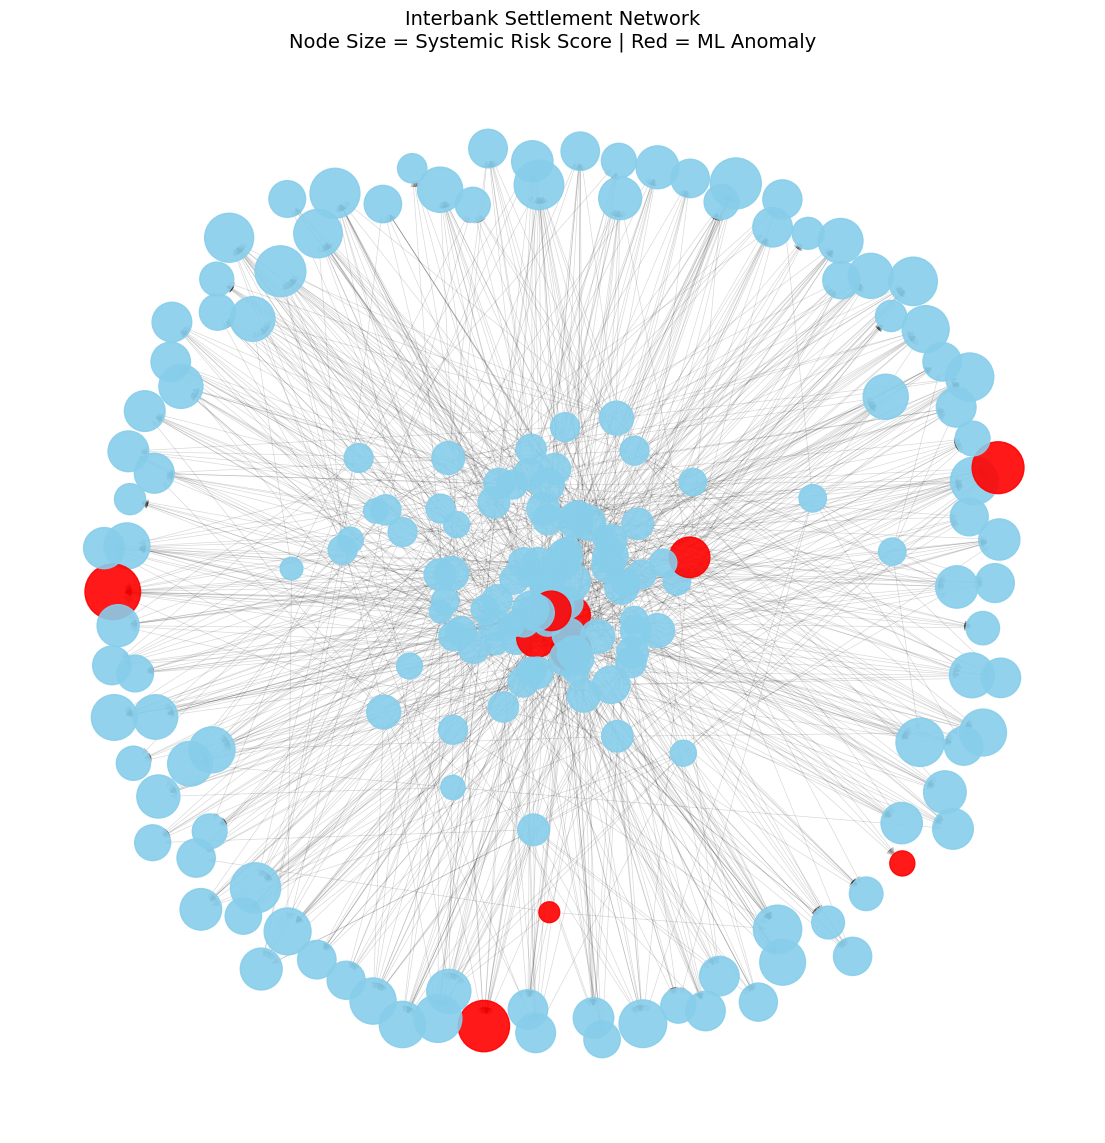

In [10]:
# Network visualisation with systemic risk & ML anomalies

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

# Reload dataset
file_path = "/content/6G_Interbank_Settlement_Dataset.csv"
df = pd.read_csv(file_path)

# Prepare edge list
df_clean = df.rename(columns={
    "Bank Sender": "sender",
    "Bank Receiver": "receiver",
    "Transaction Volume": "weight"
})
df_clean = df_clean[df_clean["sender"] != df_clean["receiver"]]
edge_list = df_clean[["sender", "receiver", "weight"]].copy()

# Build network
G = nx.DiGraph()
for _, row in edge_list.iterrows():
    G.add_edge(row["sender"], row["receiver"], weight=row["weight"])

# --- Compute network metrics ---
in_deg = nx.in_degree_centrality(G)
out_deg = nx.out_degree_centrality(G)
betweenness = nx.betweenness_centrality(G, weight="weight", normalized=True)
eigenvector = nx.eigenvector_centrality(G, weight="weight", max_iter=1000)

metrics_df = pd.DataFrame({
    "bank_id": list(G.nodes()),
    "in_degree": [in_deg[n] for n in G.nodes()],
    "out_degree": [out_deg[n] for n in G.nodes()],
    "betweenness": [betweenness[n] for n in G.nodes()],
    "eigenvector": [eigenvector[n] for n in G.nodes()]
})

# Normalise and compute systemic risk score
scaler = MinMaxScaler()
metrics_df[["in_n", "out_n", "bet_n", "eig_n"]] = scaler.fit_transform(
    metrics_df[["in_degree", "out_degree", "betweenness", "eigenvector"]]
)
metrics_df["risk_score"] = (
    0.25 * metrics_df["in_n"] +
    0.25 * metrics_df["out_n"] +
    0.25 * metrics_df["bet_n"] +
    0.25 * metrics_df["eig_n"]
)

# --- ML anomaly detection ---
iso = IsolationForest(contamination=0.05, random_state=42)
metrics_df["anomaly"] = iso.fit_predict(
    metrics_df[["in_degree", "out_degree", "betweenness", "eigenvector"]]
)

# Map attributes to graph
risk_dict = dict(zip(metrics_df["bank_id"], metrics_df["risk_score"]))
anomaly_dict = dict(zip(metrics_df["bank_id"], metrics_df["anomaly"]))

nx.set_node_attributes(G, risk_dict, "risk")
nx.set_node_attributes(G, anomaly_dict, "anomaly")

# --- Visualisation ---
plt.figure(figsize=(14, 14))

pos = nx.spring_layout(G, seed=42, k=0.25)

node_sizes = [3000 * G.nodes[n]["risk"] + 100 for n in G.nodes()]
node_colors = [
    "red" if G.nodes[n]["anomaly"] == -1 else "skyblue"
    for n in G.nodes()
]

nx.draw_networkx_edges(G, pos, alpha=0.15, width=0.5)
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.9
)

plt.title(
    "Interbank Settlement Network\n"
    "Node Size = Systemic Risk Score | Red = ML Anomaly",
    fontsize=14
)
plt.axis("off")
plt.show()


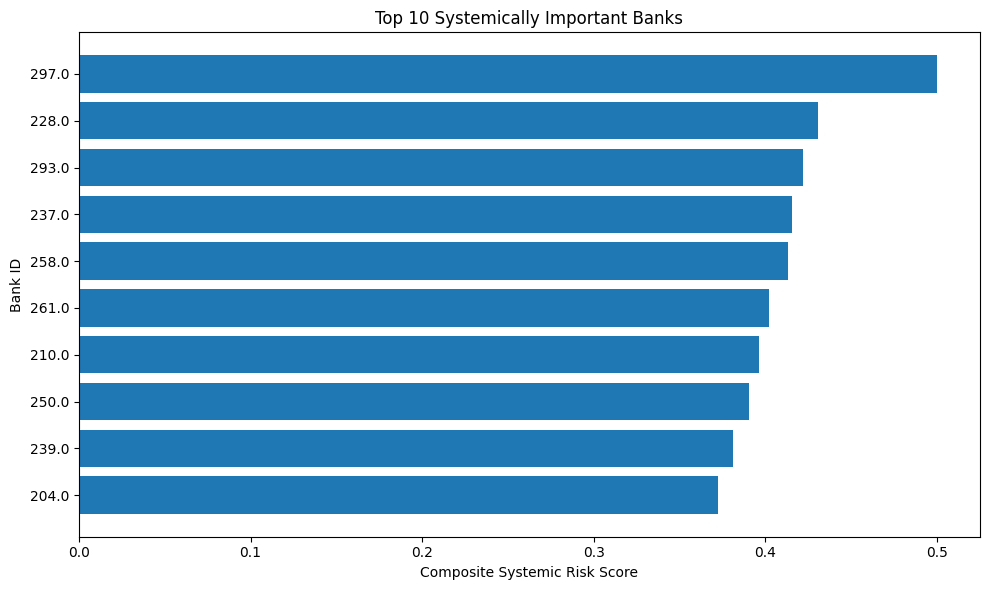

In [11]:
# Systemic risk ranking bar chart

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Reload dataset
file_path = "/content/6G_Interbank_Settlement_Dataset.csv"
df = pd.read_csv(file_path)

# Prepare edge list
df_clean = df.rename(columns={
    "Bank Sender": "sender",
    "Bank Receiver": "receiver",
    "Transaction Volume": "weight"
})
df_clean = df_clean[df_clean["sender"] != df_clean["receiver"]]
edge_list = df_clean[["sender", "receiver", "weight"]].copy()

# Build network
G = nx.DiGraph()
for _, row in edge_list.iterrows():
    G.add_edge(row["sender"], row["receiver"], weight=row["weight"])

# Compute metrics
in_deg = nx.in_degree_centrality(G)
out_deg = nx.out_degree_centrality(G)
betweenness = nx.betweenness_centrality(G, weight="weight", normalized=True)
eigenvector = nx.eigenvector_centrality(G, weight="weight", max_iter=1000)

risk_df = pd.DataFrame({
    "bank_id": list(G.nodes()),
    "in_degree": [in_deg[n] for n in G.nodes()],
    "out_degree": [out_deg[n] for n in G.nodes()],
    "betweenness": [betweenness[n] for n in G.nodes()],
    "eigenvector": [eigenvector[n] for n in G.nodes()]
})

# Normalise
scaler = MinMaxScaler()
risk_df[["in_n", "out_n", "bet_n", "eig_n"]] = scaler.fit_transform(
    risk_df[["in_degree", "out_degree", "betweenness", "eigenvector"]]
)

# Composite score
risk_df["systemic_risk_score"] = (
    0.25 * risk_df["in_n"] +
    0.25 * risk_df["out_n"] +
    0.25 * risk_df["bet_n"] +
    0.25 * risk_df["eig_n"]
)

# Select top 10
top10 = risk_df.sort_values("systemic_risk_score", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(
    top10["bank_id"].astype(str),
    top10["systemic_risk_score"]
)
plt.gca().invert_yaxis()
plt.xlabel("Composite Systemic Risk Score")
plt.ylabel("Bank ID")
plt.title("Top 10 Systemically Important Banks")
plt.tight_layout()
plt.show()


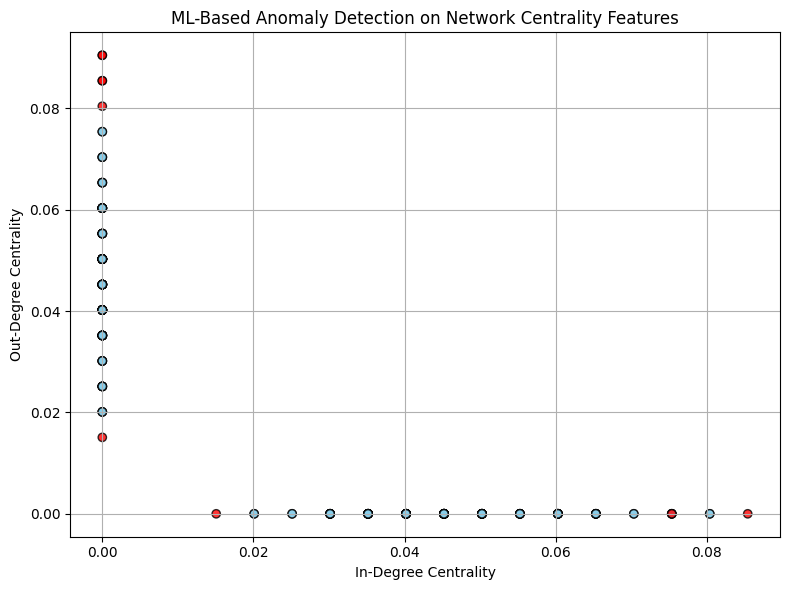

In [12]:
# ML anomaly scatter plot

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

# Reload dataset
file_path = "/content/6G_Interbank_Settlement_Dataset.csv"
df = pd.read_csv(file_path)

# Prepare edge list
df_clean = df.rename(columns={
    "Bank Sender": "sender",
    "Bank Receiver": "receiver",
    "Transaction Volume": "weight"
})
df_clean = df_clean[df_clean["sender"] != df_clean["receiver"]]
edge_list = df_clean[["sender", "receiver", "weight"]].copy()

# Build network
G = nx.DiGraph()
for _, row in edge_list.iterrows():
    G.add_edge(row["sender"], row["receiver"], weight=row["weight"])

# Compute network metrics
in_deg = nx.in_degree_centrality(G)
out_deg = nx.out_degree_centrality(G)
betweenness = nx.betweenness_centrality(G, weight="weight", normalized=True)
eigenvector = nx.eigenvector_centrality(G, weight="weight", max_iter=1000)

ml_df = pd.DataFrame({
    "bank_id": list(G.nodes()),
    "in_degree": [in_deg[n] for n in G.nodes()],
    "out_degree": [out_deg[n] for n in G.nodes()],
    "betweenness": [betweenness[n] for n in G.nodes()],
    "eigenvector": [eigenvector[n] for n in G.nodes()]
})

# ML anomaly detection
iso = IsolationForest(contamination=0.05, random_state=42)
ml_df["anomaly"] = iso.fit_predict(
    ml_df[["in_degree", "out_degree", "betweenness", "eigenvector"]]
)

# Plot
plt.figure(figsize=(8, 6))

colors = ml_df["anomaly"].map({1: "skyblue", -1: "red"})

plt.scatter(
    ml_df["in_degree"],
    ml_df["out_degree"],
    c=colors,
    alpha=0.8,
    edgecolor="k"
)

plt.xlabel("In-Degree Centrality")
plt.ylabel("Out-Degree Centrality")
plt.title("ML-Based Anomaly Detection on Network Centrality Features")
plt.grid(True)
plt.tight_layout()
plt.show()
